1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



[0.045454545454545456, 0.09090909090909091, 0.13636363636363635, 0.18181818181818182, 0.22727272727272727, 0.2727272727272727, 0.3181818181818182, 0.36363636363636365, 0.4090909090909091, 0.45454545454545453, 0.5, 0.5454545454545454, 0.5909090909090909, 0.6363636363636364, 0.6818181818181818, 0.7272727272727273, 0.7727272727272727, 0.8181818181818182, 0.8636363636363636, 0.9090909090909091, 0.9545454545454546]
[22.46 23.2  23.34 23.85 24.16 25.28 25.79 26.19 26.37 26.65 26.65 26.68
 26.73 26.75 26.76 27.93 28.09 28.79 29.75 30.19 32.97]


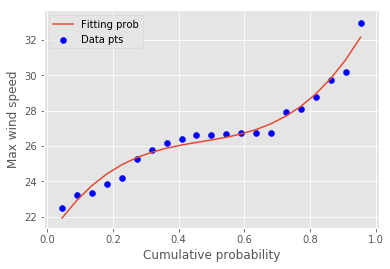

The maximum wind speed occurring every 50 years is, at 98% probability, 32.97989844019469


In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

years=[i for i in range(1,22)]
cprob = [i/(years_nb+1) for i in range(1,22)]

max_speeds=np.sort(max_speeds)

print(cprob)
print(max_speeds)

spl = UnivariateSpline(cprob,max_speeds)
fifty_prob=1-0.02
fifty_wind=spl(fifty_prob)

plt.plot(cprob,spl(cprob), label="Fitting prob")
plt.scatter(cprob,max_speeds, color="blue",label="Data pts")
plt.xlabel("Cumulative probability")
plt.ylabel("Max wind speed")
plt.legend(loc="best")
plt.show()

print("The maximum wind speed occurring every 50 years is, at 98% probability,", fifty_wind)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

[23.09206731  6.73581537 -2.29443052 15.77935195]


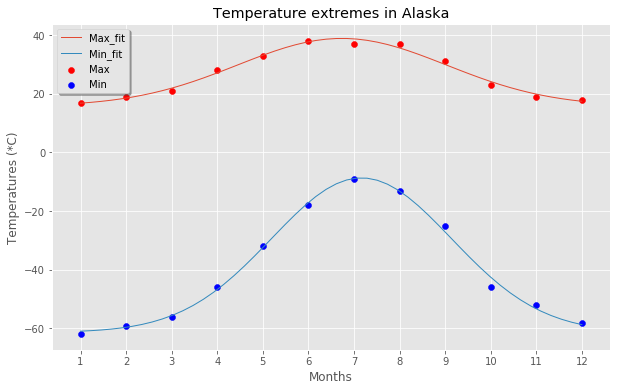

In [2]:
from scipy import optimize

months=np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
months1=[i for i in range(1,13)]
max_T=np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_T=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(months1,max_T, color="red",label="Max")
ax.scatter(months1,min_T, color="blue",label="Min")
ax.set_xlabel("Months")
ax.set_ylabel("Temperatures (*C)")
ax.set_title("Temperature extremes in Alaska")

#we use a gaussian as a fitting function
def g(x,A,mu,sigma,b):
    gauss=A*np.exp(-(x-mu)**2/(2*sigma**2))+b
    return gauss

gauss_par_max,gauss_cov_max=optimize.curve_fit(g,months1,max_T)
gauss_par_min,gauss_cov_min=optimize.curve_fit(g,months1,min_T)

print(gauss_par_max)

time=np.linspace(1,12,50)
ax.plot(time,g(time,gauss_par_max[0],gauss_par_max[1],gauss_par_max[2],gauss_par_max[3]), linewidth=1,label="Max_fit")
ax.plot(time,g(time,gauss_par_min[0],gauss_par_min[1],gauss_par_min[2],gauss_par_min[3]), linewidth=1,label="Min_fit")
ax.set_xticks(np.arange(min(months1), max(months1)+1, 1.0))
ax.legend(shadow=True, loc="best")

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


1st Min: 
       fun: -1.031628453489876
 hess_inv: array([[ 0.12931011, -0.00777533],
       [-0.00777533,  0.06177124]])
      jac: array([-1.49011612e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-0.08984202,  0.71265639])


2nd Min: 
       fun: -1.0316284534898772
 hess_inv: array([[ 0.12930974, -0.00777524],
       [-0.00777524,  0.06177124]])
      jac: array([1.49011612e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([ 0.08984201, -0.71265641])


Zero as starting point: 
       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])




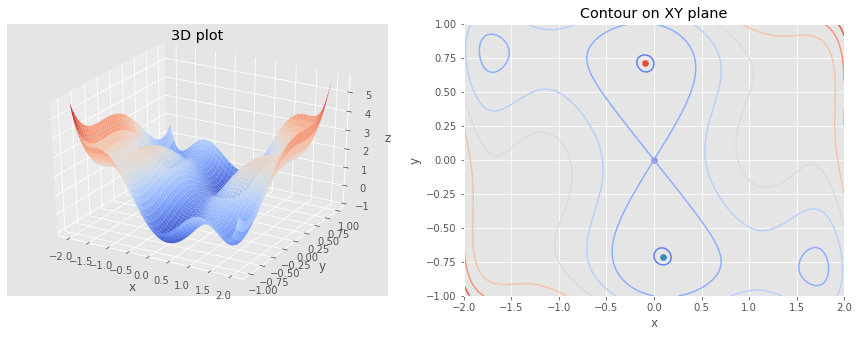

In [3]:
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import minimize

def f(x):
    return (4-2.1*x[0]**2+x[0]**4/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D plot")
ax = fig.add_subplot(1, 2, 2)
ax.contour(X, Y, Z, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Contour on XY plane")


# Minimization
amin = minimize(f,[0,0.7])
print('1st Min: \n',amin)
plt.scatter(amin.x[0],amin.x[1])
print("\n")

bmin = minimize(f,[0,-0.7])
print('2nd Min: \n',bmin)
plt.scatter(bmin.x[0],bmin.x[1])
print("\n")

zero = minimize(f,[0,0]) #guess with (0,0)
print('Zero as starting point: \n',zero) # It stays stuck at (0,0)! It's a local minimum...
plt.scatter(zero.x[0],zero.x[1])
print("\n")

plt.show()

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

The frequency peak in Lynxes is 0.09523809523809523
The frequency peak in Hares is 0.09523809523809523
The period is 10.5 years


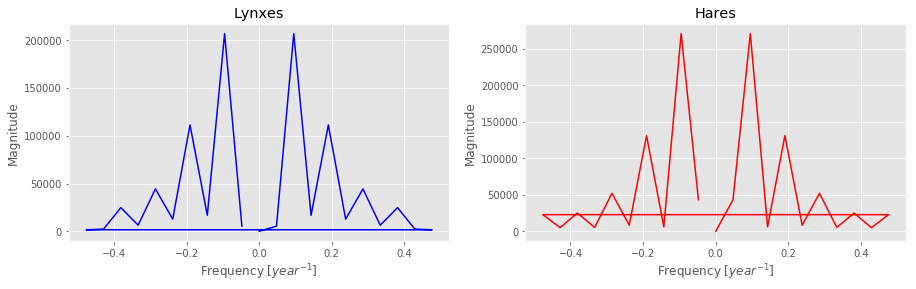

In [4]:
from scipy import fftpack as ft

data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T

#fft of the signal
#lynxes
l_fft = ft.fft(lynxes-np.mean(lynxes))
l_mag = np.abs(l_fft)
l_pha = np.angle(l_fft)
#sampling frequencies
l_freq = ft.fftfreq(21, d=1)

#hares
h_fft = ft.fft(hares-np.mean(hares))
h_mag = np.abs(h_fft)
h_pha = np.angle(h_fft)
#sampling frequencies
h_freq = ft.fftfreq(21, d=1)

#plot
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax1.plot(l_freq, l_mag, 'blue')
ax1.set_xlabel('Frequency [$year^{-1}$]')
ax1.set_ylabel('Magnitude')
ax1.set_title('Lynxes')
ax2.plot(h_freq, h_mag, 'r')
ax2.set_xlabel('Frequency [$year^{-1}$]')
ax2.set_ylabel('Magnitude')
ax2.set_title('Hares')

#looking for the peaks
peak_l=l_freq[l_mag.argmax()]
print('The frequency peak in Lynxes is',peak_l)
peak_h=h_freq[h_mag.argmax()]
print('The frequency peak in Hares is',peak_h)

#the peak in frequency is the inverse of the period
T=1/peak_l
print('The period is', T, 'years')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

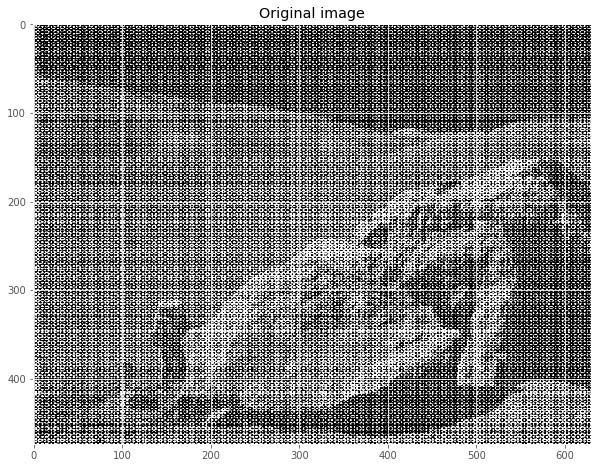

/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Max image FFT power = 126598.45
Min image FFT power = 0.09010329


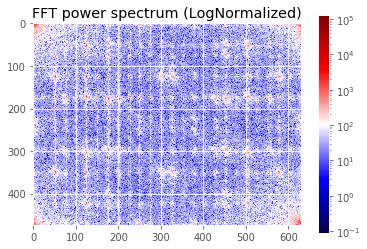

Max image FFT power = 1265.2914
Min image FFT power = 0.0


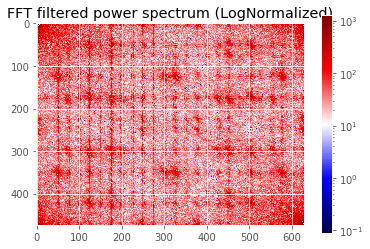

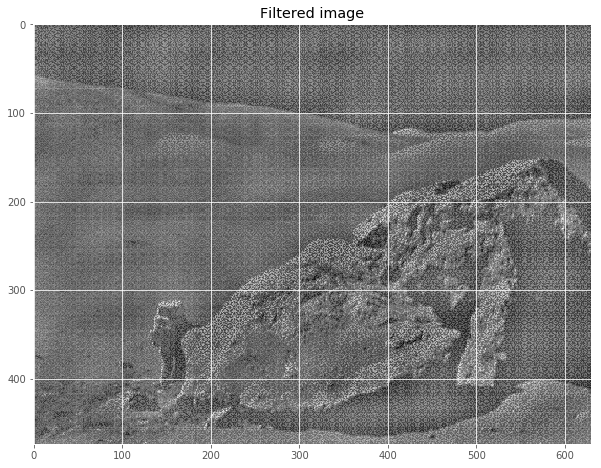

In [5]:
import matplotlib.colors as plt_c
from matplotlib import cm

image = plt.imread("moonlanding.png")
plt.figure(figsize=(10,10))
plt.imshow(image, plt.cm.gray)
plt.title("Original image")
plt.show()
image_fft = ft.fft2(image)
print("Max image FFT power =", np.abs(image_fft).max())
print("Min image FFT power =", np.abs(image_fft).min())
plt.imshow(np.abs(image_fft), norm=plt_c.LogNorm(), cmap=cm.seismic)
plt.colorbar()
plt.title("FFT power spectrum (LogNormalized)")
plt.show()
max_image_fft = np.abs(image_fft).max()
filtered_image_fft = image_fft.copy()
filtered_image_fft[np.abs(filtered_image_fft) > 0.01*max_image_fft] = 0
print("Max image FFT power =", np.abs(filtered_image_fft).max())
print("Min image FFT power =", np.abs(filtered_image_fft).min())
plt.imshow(np.abs(filtered_image_fft), norm=plt_c.LogNorm(), cmap=cm.seismic)
plt.colorbar()
plt.title("FFT filtered power spectrum (LogNormalized)")
plt.show()
filtered_image = ft.ifft2(filtered_image_fft).real
plt.figure(figsize=(10,10))
plt.imshow(filtered_image, plt.cm.gray)
plt.title("Filtered image")
plt.show()